# Kaggle Machine Learning Project
## Project: Titanic - Machine Learning from Disaster 

The problem to be solved is to predict the passengers that survive the Titanic. The goal is to use passenger characteristics and location to determine if a passenger is likely to die or survive. Based off the Kaggle prompt and the expected typed of output, this problem is a supervised classification problem. A potential way to solve this problem is to use a neural network classifier. For the sake of exploration, I hope to use other machine learning techniques like random forests and support vector machines to classify the passengers aboard the Titanic. The benchmark model will be a simple linear regression. The score to determine usefulness of the solution is the accuracy, the percentage of passengers correctly predicted.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [9]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
# Pretty display for notebooks
%matplotlib inline

#Import Train Data
#Grab train_x data excluding Survivors
train_df = pd.read_csv('Data/train.csv')
train_df = train_df.drop('Cabin', axis =1)
train_df = train_df.drop('Name', axis = 1)
train_df = train_df.dropna()
train_x = train_df.drop('Survived', axis = 1)

#Grab train_y only with Survivors
features = list(train_df)
print features
train_y = train_df.drop(features, axis = 1)


#Import Test Data
test_df = pd.read_csv('Data/test.csv')
test_df = test_df.drop('Cabin', axis = 1)
test_df = test_df.drop('Name', axis =1)
test_df = test_df.dropna()

# Success Check
print "Titanic Disaster training dataset has {} rows of data with {} variables each.".format(*train_df.shape)
print "Titanic Disaster testing dataset has {} rows of data with {} variables each.".format(*test_df.shape)

['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']
Titanic Disaster training dataset has 712 rows of data with 10 variables each.
Titanic Disaster testing dataset has 331 rows of data with 9 variables each.


## Data Exploration

The data can be described as

1. survival = Survival
1. pclass = Ticket class
1. sex = Sex	
1. Age = Age in years	
1. sibsp =	# of siblings / spouses aboard the Titanic	
1. parch =	# of parents / children aboard the Titanic	
1. ticket =	Ticket number	
1. fare = Passenger fare	
1. cabin =	Cabin number	
1. embarked =	Port of Embarkation

I used Pandas describe() function to explore the numbers data. However, this function does not take into consideration the data that involves strings such as: 'Name', 'Sex', 'Ticket', 'Cabin', and 'Embarked'. 'Sex' looks like a good candidate to change 'Male' and "Female' to binary values using one hot encoding. PassengerId doesn't mean much based on these statistics as its just a unique identifier for each individual. Pclass seems to show that most people were of Pclass 2 or 3. Age shows that most people were approximately 30 years old. The minimum and maximum also suggests that there are elderly and children on board. The count of the age being lower than other features indicates that there is missing data that has to be dealt with. Sibsp and Parch show that the majority of passengers came alone or possibly with friends depending on what the data represents. Fare seems to indicate that there were 3 ticket classes as the 25-75% quartiles seem fairly different. It is interesting to note that the mean seems to be in the 75% quartile of data possibly due to a few very large fares indicated by the max being $512. Cabin is most likely going to be removed as a feature because there is too much missing data and it would be hard to make conclusions when most people's information is unknown. It seems logical to remove Name as they are all unique identifiers represented by the PassengerID.

In [10]:
#Grab list of keypoint names
#print features
print train_df.isnull().sum()
train_df.describe()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.589888,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,258.683191,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,677.250000,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## Exploratory Visualization

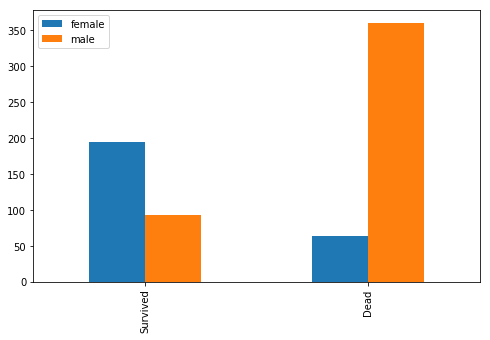

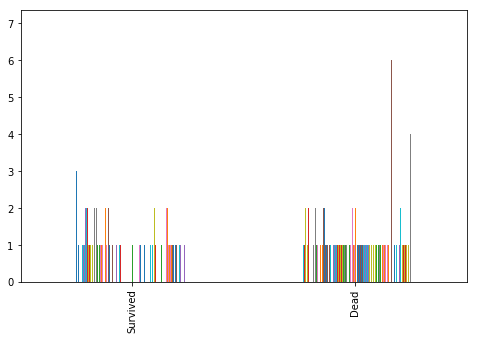

In [89]:
sex_survive = train_df[train_df['Survived']==1]['Sex'].value_counts()
sex_dead = train_df[train_df['Survived']==0]['Sex'].value_counts()
sex_df = pd.DataFrame([sex_survive,sex_dead])
sex_df.index = ['Survived', 'Dead']
sex_df.plot(kind='bar', stacked = False, figsize=(8,5))

ticket_survive = train_df[train_df['Survived']==1]['Ticket'].value_counts()
ticket_dead = train_df[train_df['Survived']==0]['Ticket'].value_counts()
ticket_df = pd.DataFrame([ticket_survive,ticket_dead])
ticket_df.index = ['Survived', 'Dead']
ticket_df.plot(kind='bar', stacked = False, figsize = (8,5), legend=False)

## Preprocessed Data

In [3]:
#Show dimensions
print train_x.shape
print train_y.shape

#Change female and male to integer values where male = 0 and female = 1
train_x['Sex'] = train_x['Sex'].map({'female':1, 'male': 0})
train_x['Embarked'] = train_x['Embarked'].map({'S':0, 'C':1, 'Q':2})
print train_x

(712, 9)
(712, 0)
     PassengerId  Pclass  Sex   Age  SibSp  Parch            Ticket      Fare  \
0              1       3    0  22.0      1      0         A/5 21171    7.2500   
1              2       1    1  38.0      1      0          PC 17599   71.2833   
2              3       3    1  26.0      0      0  STON/O2. 3101282    7.9250   
3              4       1    1  35.0      1      0            113803   53.1000   
4              5       3    0  35.0      0      0            373450    8.0500   
6              7       1    0  54.0      0      0             17463   51.8625   
7              8       3    0   2.0      3      1            349909   21.0750   
8              9       3    1  27.0      0      2            347742   11.1333   
9             10       2    1  14.0      1      0            237736   30.0708   
10            11       3    1   4.0      1      1           PP 9549   16.7000   
11            12       1    1  58.0      0      0            113783   26.5500   
12        

## Benchmark Model

In [4]:
regr = LinearRegression()
regr.fit(train_x,train_y)
#error_vals = mean_squared_error(y_test, regr.predict(X_test))**0.5
#print "The benchmark root mean squared error is %s" % error_vals

ValueError: could not convert string to float: SOTON/OQ 392076